## Introduction
### Resources used
* For loading dataset in kaggle: https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463
* For exploring data and training the model, the code was adapted from this notebook: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

## Loading dataset from Kaggle

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision.image import *

In [0]:
!pip install kaggle

In [0]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import getpass
print("Paste the content from kaggle.json, then press Enter:")
tokenString = getpass.getpass()
with open('/content/.kaggle/kaggle.json', 'w') as file:
  file.write(tokenString)

Paste the content from kaggle.json, then press Enter:
··········


In [0]:
!mkdir /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p /content/skin-cancer-data

 99% 321M/325M [00:07<00:00, 50.4MB/s]
100% 325M/325M [00:07<00:00, 48.4MB/s]


In [0]:
!cd skin-cancer-data; unzip *.zip

Archive:  skin-cancer-malignant-vs-benign.zip
  inflating: data/test/benign/1.jpg  
  inflating: data/test/benign/10.jpg  
  inflating: data/test/benign/1003.jpg  
  inflating: data/test/benign/1006.jpg  
  inflating: data/test/benign/1013.jpg  
  inflating: data/test/benign/1018.jpg  
  inflating: data/test/benign/1019.jpg  
  inflating: data/test/benign/1023.jpg  
  inflating: data/test/benign/1025.jpg  
  inflating: data/test/benign/1029.jpg  
  inflating: data/test/benign/1033.jpg  
  inflating: data/test/benign/1034.jpg  
  inflating: data/test/benign/1042.jpg  
  inflating: data/test/benign/1044.jpg  
  inflating: data/test/benign/105.jpg  
  inflating: data/test/benign/1055.jpg  
  inflating: data/test/benign/1061.jpg  
  inflating: data/test/benign/1070.jpg  
  inflating: data/test/benign/1074.jpg  
  inflating: data/test/benign/1077.jpg  
  inflating: data/test/benign/1080.jpg  
  inflating: data/test/benign/1087.jpg  
  inflating: data/test/benign/1088.jpg  
  inflating: data

## Data augmentation

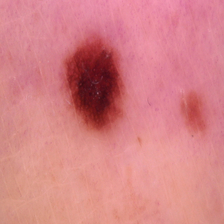

In [0]:
im=open_image('/content/skin-cancer-data/data/train/benign/637.jpg')
im

In [0]:
tfms = get_transforms(max_rotate=180)
def get_ex(): return im

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

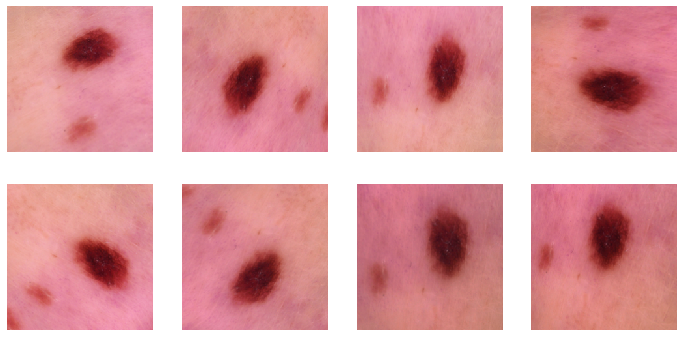

In [0]:
plots_f(2, 4, 12, 6, size=224)

## Defining the DataBunch object

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [0]:
!ls -l /content/skin-cancer-data/data/test/benign | wc -l;
!ls -l /content/skin-cancer-data/data/test/malignant | wc -l;
!ls -l /content/skin-cancer-data/data/train/benign | wc -l;
!ls -l /content/skin-cancer-data/data/train/malignant | wc -l;

361
301
1441
1198


In [0]:
!ls -l /content/skin-cancer-data/test/benign | wc -l;
!ls -l /content/skin-cancer-data/test/malignant | wc -l;
!ls -l /content/skin-cancer-data/train/benign | wc -l;
!ls -l /content/skin-cancer-data/train/malignant | wc -l;

361
301
1441
1198


In [0]:
!ls /content/skin-cancer-data

data  skin-cancer-malignant-vs-benign.zip  test  train


In [0]:
!rm -r /content/skin-cancer-data/data;

In [0]:
!rm -r /content/skin-cancer-data/skin-cancer-malignant-vs-benign.zip

In [0]:
#data = ImageDataBunch.from_folder("/content/skin-cancer-data", ds_tfms=tfms)
path = Path('/content/skin-cancer-data/train').resolve()
data = (ImageList.from_folder(path)
        .split_by_rand_pct(valid_pct = 0.2)
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize())

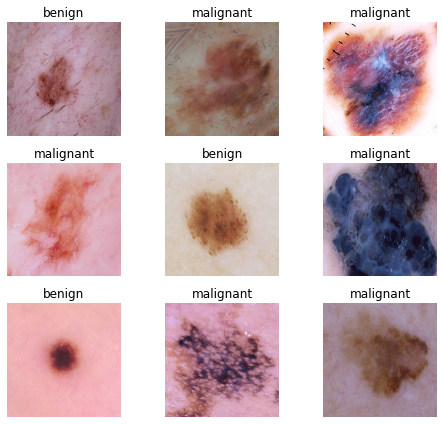

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)

['benign', 'malignant']


In [0]:
data

ImageDataBunch;

Train: LabelList (2110 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,malignant,malignant,malignant,malignant
Path: /content/skin-cancer-data/train;

Valid: LabelList (527 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,benign,malignant,malignant,benign
Path: /content/skin-cancer-data/train;

Test: None

## Training: ResNet34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [0]:
# This callback is necessary to record training loss with Dropout layers disabled.
# When fit_one_cycle() returns train_loss and accuracy, it is with Dropout enabled.
# This leads to misleading data when comparing to validation loss.
class LossRecorderCB(Callback):
  def __init__(self):
    # Record [loss, accuracy] for train set
    self.record_train = {}
    # Record [loss, accuracy] for valid set
    self.record_valid = {}
    self.epoch = 1

  def on_epoch_end(self, **kwargs):
    #e = kwargs['epoch']
    self.record_train[self.epoch] = learn.validate(data.train_dl)
    self.record_valid[self.epoch] = learn.validate(data.valid_dl)
    self.epoch += 1

In [0]:
LRCB = LossRecorderCB()

In [0]:
learn.fit_one_cycle(6, callbacks=[LRCB])

epoch,train_loss,valid_loss,accuracy,time
0,0.690962,0.471430,0.800759,00:16
1,0.606847,0.420391,0.829222,00:16
2,0.536965,0.367083,0.836812,00:16
3,0.454460,0.326019,0.850095,00:15
4,0.402241,0.315698,0.855787,00:15
5,0.368391,0.316348,0.853890,00:15


In [0]:
print(LRCB.record_train)
print(LRCB.record_valid)

{1: [0.40305275, tensor(0.8413)], 2: [0.36014858, tensor(0.8477)], 3: [0.30859196, tensor(0.8662)], 4: [0.28959465, tensor(0.8677)], 5: [0.27701426, tensor(0.8784)], 6: [0.25959575, tensor(0.8813)]}
{1: [0.47143018, tensor(0.8008)], 2: [0.420391, tensor(0.8292)], 3: [0.36708295, tensor(0.8368)], 4: [0.3260191, tensor(0.8501)], 5: [0.31569785, tensor(0.8558)], 6: [0.31634796, tensor(0.8539)]}


In [0]:
learn.save('stage-1')

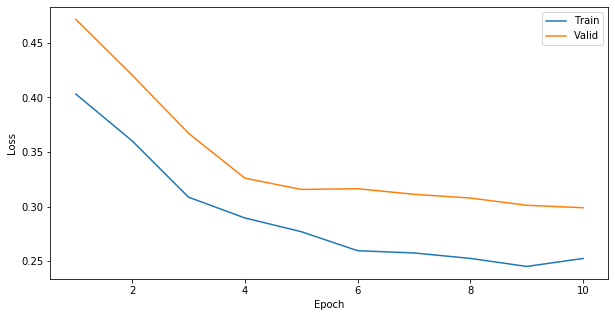

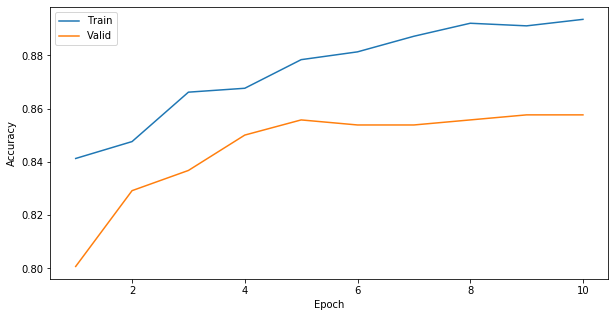

In [0]:
# Input: record_train or record_valid object
# Output: dictionary with keys: epochList, lossList, accList
def unpackRecord(rec):
  ret = {}
  ret['epochList'] = []
  ret['lossList'] = []
  ret['accList'] = []
  for k, v in rec.items():
    ret['epochList'].append(k)
    ret['lossList'].append(v[0])
    ret['accList'].append(v[1].item())
  return ret

def plotLRCB(LRCB):
  trainDict = unpackRecord(LRCB.record_train)
  validDict = unpackRecord(LRCB.record_valid)
  figsize = (10, 5)

  fig, ax1 = plt.subplots(1, 1, figsize=figsize)
  ax1.plot(trainDict['epochList'], trainDict['lossList'], label='Train')
  ax1.plot(validDict['epochList'], validDict['lossList'], label='Valid')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  fig, ax2 = plt.subplots(1, 1, figsize=figsize)
  ax2.plot(trainDict['epochList'], trainDict['accList'], label='Train')
  ax2.plot(validDict['epochList'], validDict['accList'], label='Valid')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

plotLRCB(LRCB)

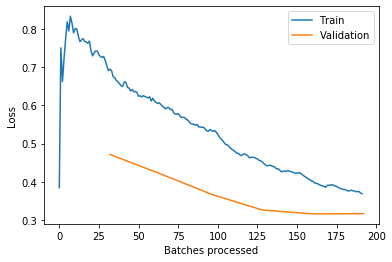

In [0]:
# This plot shows training loss as higher than validation loss.
# The reason is that Dropout is enabled during training.
# Also, it is the moving average of the losses during training, so it has some traces of using bad weights near the beginning.
learn.recorder.plot_losses()

## Unfreezing, fine-tuning, and learning rates

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


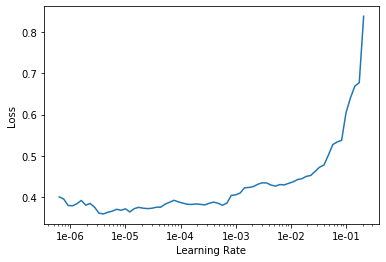

In [0]:
learn.unfreeze()
learn.load('stage-1')
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4), callbacks=[LRCB])

epoch,train_loss,valid_loss,accuracy,time
0,0.317357,0.311239,0.853890,00:16
1,0.315179,0.307826,0.855787,00:16
2,0.305532,0.301186,0.857685,00:16
3,0.294218,0.298977,0.857685,00:15


In [0]:
print(LRCB.record_train)
print(LRCB.record_valid)

{1: [0.40305275, tensor(0.8413)], 2: [0.36014858, tensor(0.8477)], 3: [0.30859196, tensor(0.8662)], 4: [0.28959465, tensor(0.8677)], 5: [0.27701426, tensor(0.8784)], 6: [0.25959575, tensor(0.8813)], 7: [0.2575361, tensor(0.8872)], 8: [0.25255537, tensor(0.8921)], 9: [0.24519314, tensor(0.8911)], 10: [0.2524893, tensor(0.8936)]}
{1: [0.47143018, tensor(0.8008)], 2: [0.420391, tensor(0.8292)], 3: [0.36708295, tensor(0.8368)], 4: [0.3260191, tensor(0.8501)], 5: [0.31569785, tensor(0.8558)], 6: [0.31634796, tensor(0.8539)], 7: [0.31123912, tensor(0.8539)], 8: [0.30782604, tensor(0.8558)], 9: [0.3011858, tensor(0.8577)], 10: [0.29897735, tensor(0.8577)]}


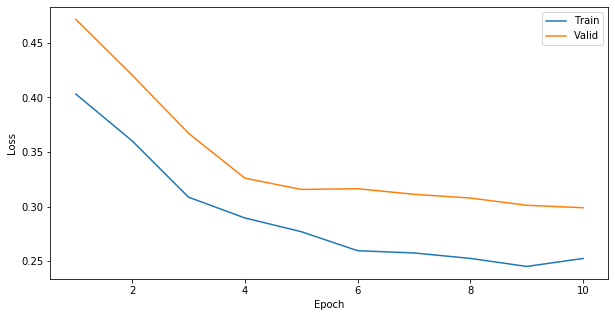

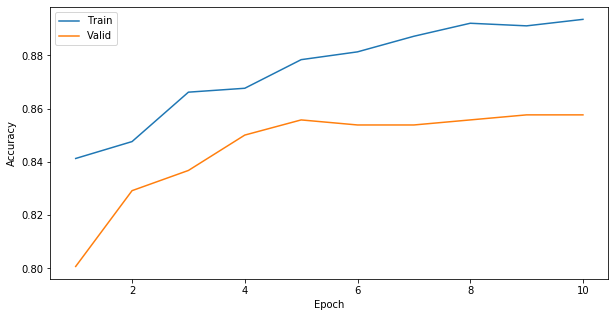

In [0]:
plotLRCB(LRCB)

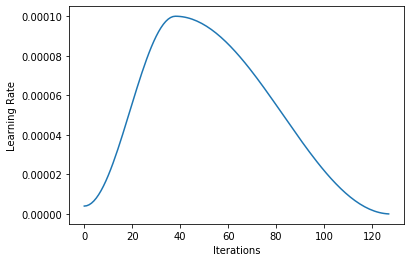

In [0]:
learn.recorder.plot_lr()

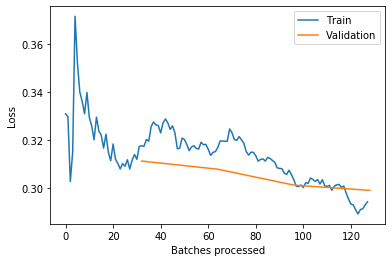

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2');

## Evaluating test error

In [0]:
path = Path('/content/skin-cancer-data').resolve()
data_test = (ImageList.from_folder(path)
  .split_by_folder(train='test', valid='test')
  .label_from_folder()
  .databunch()
  .normalize()) 
# Return [loss, accuracy] for test set
learn.validate(data_test.valid_dl)

[0.29894406, tensor(0.8576)]